In [1]:
import networkx as nx
import pickle
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import igraph as ig
tqdm.pandas()
from collections import Counter
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
# plt.rcParams['figure.facecolor'] = '#31394dff'

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)

In [2]:
### Cargo el json con la informacion de cada paquete, y el grafo

filename = '../../state_files/proc_jsons.json'
with open(filename, 'r') as f:
    pkg_json = json.load(f)

### Re-formateo el la lista de diccionarios por un diccionario de diccionarios, 
### con el nombre del paquete (nodo) de llave para la informacion.
info_dict = {}
for package in pkg_json:
    info_dict[package.pop('Name')] = package
del pkg_json

### Cargo el Dataframe con el info_dict
df = pd.DataFrame(info_dict)
df = df.T
del info_dict

# Limpiado del DF

## Formateo las columnas del DataFrame, y limpio los Nones

In [3]:
@np.vectorize
def format_strings(s: str):
    """
    Aplico un formato unificado para los paquetes.
    Esta funcion es importante porque las dependencias en varios de los paquetes
    aparecen con un formato distinto al nombre de las librerias (por ej. Numpy 
    es la libreria, y en las dependencias puede aparecer como NumPy, numpy, numpy[1.02], etc)

    """
    fmt_string = s.lower() # Normalizo todo a minuscula
    fmt_string = re.sub(r'[\_\-\| .,/\\;:=~]', '-', fmt_string) # Unifico separadores
    fmt_string = re.sub(r'\(\[\{', '[', fmt_string) # Unifico parentesis
    fmt_string = re.sub(r'\)\]\}', ']', fmt_string) # IDEM
    return fmt_string

# Normalizo a minuscula los nombres de los paquetes.
new_ix = format_strings(np.array(df.index))
df = df.rename(index={old_name: new_name for old_name, new_name in zip(df.index, new_ix)})

In [4]:
### Remplazo strings que indican elemento faltante por None
to_replace = ['', 'UNKNOWN', 'none', 'None', 'empty', 'nothing', np.nan, 'NaN', 'nan']
df.replace(to_replace, None, inplace=True)

### Remplazo los nones en dependencies por listas vacias
df.Dependencies = df.Dependencies.apply(lambda x: [] if x == None else x)

In [5]:
print(f'Number of packages: {len(df)}')

for column in ['Tags', 'Licence', 'Python Version']:
    print(f'NaN count {column} = {sum(df[column].isna())}')

### para el resto de las columnas, reviso cuantas tienen listas vacias
for column in ['Dependencies', 'Package Version', 'Classifiers']:
    print(f'NaN count {column} = {sum(~df[column].astype(bool))}')

Number of packages: 398843
NaN count Tags = 262638
NaN count Licence = 142794
NaN count Python Version = 252357
NaN count Dependencies = 228134
NaN count Package Version = 0
NaN count Classifiers = 99754


In [6]:
@np.vectorize
def format_dependencies(s: str):
    """
    Formateo cosas particulares que aparecen en las dependencias.
    """

    fmt_string = re.sub(r'\[.*\]', '', s) # Le quito la parte entre corchetes
    fmt_string = fmt_string.rstrip('-') # Le quito la - del final
    
    return fmt_string

Descarto los paquetes que tienen 0 dependencias y dependen de 0 paquetes

In [7]:
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(format_strings(x)) if 
                                              np.logical_and(type(x) == list, bool(x)) else x)
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(format_dependencies(x)) if
                                              np.logical_and(type(x) == list, bool(x)) else x)

### Le quito posibles dependencias repetidas
df['Dependencies'] = df['Dependencies'].apply(lambda x: list(set(x)))

Quito autoenlaces

In [8]:
def remove_self_edges(x):
    """
    Quita dependencias de paquetes con sigo mismo.
    """
    
    dependencies = x.Dependencies.copy()
    while x.name in dependencies:
        dependencies.remove(x.name)
        x['Dependencies'] = dependencies
    return x

df = df.apply(remove_self_edges, axis=1)

Agrego columnas de dependencias, y quito nodos sin enlaces entrantes ni salientes

In [9]:
dep_pakage_counter = []
for dep in df['Dependencies']:
    if np.logical_and(type(dep) == list, bool(dep)):
        dep_pakage_counter += dep 

dep_pakage_counter = Counter(dep_pakage_counter)
dep_pakage_counter = dict(sorted(dep_pakage_counter.items(), key=lambda x: x[1], reverse=True))

# saco los paquetes que no estan indexados en el dataframe (los guarde como 'packages_not_found.txt')
packages_not_found = set(dep_pakage_counter.keys()) - set(df.index)
dep_pakage_counter = {k: i for k, i in dep_pakage_counter.items() if k in df.index}

# Creo la columna de la cantidad de librerias que dependen de cada lib, y la relleno con lo que obtuvimos recien
df['Dependant Libraries Count'] = np.zeros(len(df))
df.loc[dep_pakage_counter.keys(), 'Dependant Libraries Count'] = list(dep_pakage_counter.values())

Modifico las dependencias quitandole las librerias que no estan como indices en el DF

In [10]:
def clean_dependencies(deps):
    global packages_not_found
    
    ret = deps
    deps_not_found = list(set(packages_not_found) & set(deps))
    
    if bool(deps_not_found):
        for dnf in deps_not_found:
            ret.remove(dnf)
    return ret

df['Dependencies'] = df['Dependencies'].apply(clean_dependencies)

Quito librerias sin enlaces

In [11]:
df = df[np.logical_or(df['Dependant Libraries Count'] > 0, df['Dependencies'].astype(bool))]

# Classifiers

Primero, observo que los classifiers pueden tener como maximo 5 elementos [grupo, subgrupo, ..., subsubsubsubgrupo]

In [12]:
def format_classifiers(classifiers, column, ONLY_KEEP_FIRST=False, ONLY_GET_SUBTOPICS=False):
    
    # Si es None o una lista vacia, devuelvo None
    if bool(classifiers) == False:
        ret = None

    else:
        x = []
        for c in classifiers:
            if ONLY_KEEP_FIRST:
                split_classifier = c.split(' :: ')
            else:
                split_classifier = c.split(' :: ', 1)

            if split_classifier[0] == column:
                x.append(split_classifier[1])
        
        # Si no hay coincidencias, devuelvo None
        if bool(x) == False:
            ret = None
        
        else:
            ret = ''
            x = sorted(set(x))
            for element in x:
                ret += element
                ret += ' - '
            ret = ret.rstrip(' - ')

    return ret

In [13]:
def format_sub_classifiers(classifiers, column, ONLY_KEEP_FIRST=False):
    
    if classifiers == None:
        ret = None
    
    else:
        x = []
        classifiers_list = classifiers.split(' - ')
    
        for c in classifiers_list:
            if ONLY_KEEP_FIRST:
                split_classifier = c.split(' :: ')
            else:
                split_classifier = c.split(' :: ', 1)

            # Si el topico coincide, me llevo el subtopico. Si no tiene subtopico, me llevo el topico
            if (split_classifier[0] == column):
                if (len(split_classifier) > 1):
                    x.append(split_classifier[1])
                else:
                    x.append(split_classifier[0])
        
        if bool(x) == False:
            ret = None
        
        else:
            ret = ''
            x = sorted(set(x))
            for element in x:
                ret += element
                ret += ' - '
            ret = ret.rstrip(' - ')
    return ret

In [14]:
### Armo la lista de topicos de 1er nivel (los que aparecen antes del ' :: ')

topics = []
for classifiers in tqdm(df['Classifiers']):
    if bool(classifiers) == False:
        pass
    else: 
        for c in classifiers:
            split_classifier = c.split(' :: ')
            topics.append(split_classifier[0])

topics = set(topics)

100%|██████████| 185314/185314 [00:00<00:00, 539267.70it/s]


In [15]:
topics

{'Development Status',
 'Environment',
 'Framework',
 'Intended Audience',
 'License',
 'Natural Language',
 'Operating System',
 'Programming Language',
 'Topic',
 'Typing'}

In [16]:
# Creo una columna para cada classifier.

for topic in tqdm(topics):
    df[topic] = df['Classifiers'].apply(format_classifiers, column=topic, ONLY_KEEP_FIRST=False, ONLY_GET_SUBTOPICS=False)

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


In [17]:
subtopics = []
for topics in tqdm(df['Topic']):
    if topics == None:
        pass

    else: 
        topics_list = topics.split(' - ')
        for t in topics_list:
            split_topics = t.split(' :: ')
            if len(split_topics) > 1:
                subtopics.append(split_topics[0])

subtopics = set(subtopics)

100%|██████████| 185314/185314 [00:00<00:00, 2222479.33it/s]


In [18]:
for s in subtopics:
    df['Topic ' + s] = df['Topic'].apply(format_sub_classifiers, column=s, ONLY_KEEP_FIRST=True)

In [19]:
# Ahora me quedo solo con el topico a orden 1 en esta columna
df['Topic First Order'] = df['Classifiers'].apply(format_classifiers, column='Topic', ONLY_KEEP_FIRST=True)

## Programming language

Notese que aunque hayan varios paquetes que tienen bajo "programming language" otro lenguaje que no es python, la gran mayoria tiene al menos una version de python anotada.

Para estos ~60 casos, descartamos los nodos.

In [20]:
# descarto las librerias que no tienen a python como uno de sus languages (las que no especifican, las dejo)
df = df[np.logical_or(df['Programming Language'].isnull(), df['Programming Language'].str.contains('Python'))]

## Gráfico de tópicos

In [21]:
def format_topics(topics):
    '''
    Convierte a listas a los topicos separados por '-'
    '''
    
    # Si es None o una lista vacia, devuelvo None
    if bool(topics) == False:
        topic_list = None

    else:
        topic_list = sorted(topics.split(' - '))
    return topic_list

In [22]:
df['Topic First Order'] = df['Topic First Order'].apply(format_topics)
df['Topic'] = df['Topic'].apply(format_topics)
for subtopic in subtopics:
    df['Topic '+subtopic] = df['Topic '+subtopic].apply(format_topics)
df['Intended Audience'] = df['Intended Audience'].apply(format_topics)

In [23]:
### Corrijo algo de las columnas de 'Topic {topic}'
def subtopics_correction(x, topic: str):
    if bool(x) == False:
        pass
    else:
        if np.logical_and(topic in x, len(x)>1):
            x.remove(topic)
    return x

topics_list = ['Topic Education', 'Topic Software Development', 'Topic Database',
       'Topic Documentation', 'Topic Multimedia',
       'Topic Scientific/Engineering', 'Topic Text Editors',
       'Topic Games/Entertainment', 'Topic Office/Business', 'Topic Terminals',
       'Topic Desktop Environment', 'Topic Sociology', 'Topic Text Processing',
       'Topic Communications', 'Topic System', 'Topic Internet',
       'Topic Security']

for topic in topics_list:
    df[topic].apply(subtopics_correction, topic=topic[6:])

In [24]:
all_topics = []
for topics in df['Topic'].values:
    if bool(topics) == True:
        all_topics += topics
        
topics_counter = dict(Counter(all_topics))
topics_counter = dict(sorted(topics_counter.items(), key=lambda x: x[0]))

### Por ejemplo, puedo tener un counter de todos los subtopicos de 'Communications' haciendo esto:
communications_topic = {k: v for k, v in topics_counter.items() if k.startswith('Communications')}
science_topic = {k: v for k, v in topics_counter.items() if k.startswith('Scientific/Engineering')}

In [25]:
science_indexes = []
for index, topics in enumerate(df['Topic First Order'].values):
    if bool(topics) != 0:
        if 'Scientific/Engineering' in topics:
            science_indexes.append(index)

In [26]:
i = 0
for index, (topics, subtopics) in enumerate(zip(df['Topic First Order'], df['Topic Scientific/Engineering'])):
    if bool(topics) != False:
        if np.logical_and('Scientific/Engineering' in topics, bool(subtopics) == False):
            # print(topics)
            print('Encontre fallo en ', index)
            i += 1

### Como no falla, esta  bien armada la columna de 'Topic {topic}'

In [27]:
def format_topics_for_propagation(x, subtopics: list):
    
    if bool(x['Topic First Order']) == False:
        topic_list = x['Topic First Order']
        pass
    else:
        topic_list = x['Topic First Order'].copy()
        for subtopic in subtopics:
            if bool(x['Topic '+subtopic]) == False:
                pass
            else:
                topic_list.remove(subtopic)
                topic_list += x['Topic '+subtopic]
            
            topic_list = sorted(topic_list)

    return topic_list

df['Topics for Propagation'] = df.apply(format_topics_for_propagation, axis=1, subtopics=['Scientific/Engineering', 'System', 'Internet'])

In [28]:
### Tambien, quito la etiqueta de SoftDev de la columna de Topics for Propagation
def remove_softdev(x):
    
    if bool(x) == False:
        pass
    else:
        if 'Software Development' in x:
            x.remove('Software Development')
    return x

df['Topics for Propagation'] = df['Topics for Propagation'].apply(remove_softdev)

In [30]:
### PRUEBA DE QUE FUNCIONA LO QUE HICE.
df.iloc[science_indexes][['Topic First Order', 'Topic Scientific/Engineering', 'Topics for Propagation']]

,Topic First Order,Topic Scientific/Engineering,Topics for Propagation
2ppy,"[Scientific/Engineering, Software Development]",[Artificial Intelligence],[Artificial Intelligence]
3dcore,[Scientific/Engineering],[Physics],[Physics]
3di-cmd-client,[Scientific/Engineering],[Scientific/Engineering],[Scientific/Engineering]
aa-stat,[Scientific/Engineering],"[Bio-Informatics, Chemistry, Physics]","[Bio-Informatics, Chemistry, Physics]"
adgt,[Scientific/Engineering],[Scientific/Engineering],[Scientific/Engineering]
...,...,...,...
ztlearn,"[Scientific/Engineering, Software Development]",[Artificial Intelligence],[Artificial Intelligence]
ztv,"[Multimedia, Scientific/Engineering]",[Astronomy],"[Astronomy, Multimedia]"
zugbruecke,"[Scientific/Engineering, Software Development, System, Utilities]",[Scientific/Engineering],"[Operating System, Operating System Kernels, Scientific/Engineering, Utilities]"
zwembad,[Scientific/Engineering],[Scientific/Engineering],[Scientific/Engineering]


### Plotting

In [65]:
def plot_pie_chart(topic_column: str, thresh_for_others=0, include_others=True):

    topics_all = [] # Lista que va a contar los topicos de todas las librerias
    for topics in tqdm(df[topic_column]):
        if bool(topics):
            topics_all += topics

    topics_all = dict(Counter(topics_all))
    topics_all = dict(sorted(topics_all.items(), key=lambda x: x[1], reverse=True))

    dict_all_toplot = {k: v for k, v in topics_all.items() if v > thresh_for_others}
    
    if include_others:
        dict_all_toplot['Others'] = sum([v for v in topics_all.values() if v < thresh_for_others])

    patches, labels, pct_texts = plt.pie(dict_all_toplot.values(),
                                        labels=dict_all_toplot.keys(), rotatelabels=90, 
                                        startangle=180, 
                                        autopct=lambda p: f"{p:.2f}%  ({p * sum(dict_all_toplot.values()) / 100:.0f})",
                                        textprops={'fontsize': 8})

    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())
        label.set_rotation(0)
        pct_text.set_fontsize(6)

100%|██████████| 185242/185242 [00:00<00:00, 1813893.35it/s]


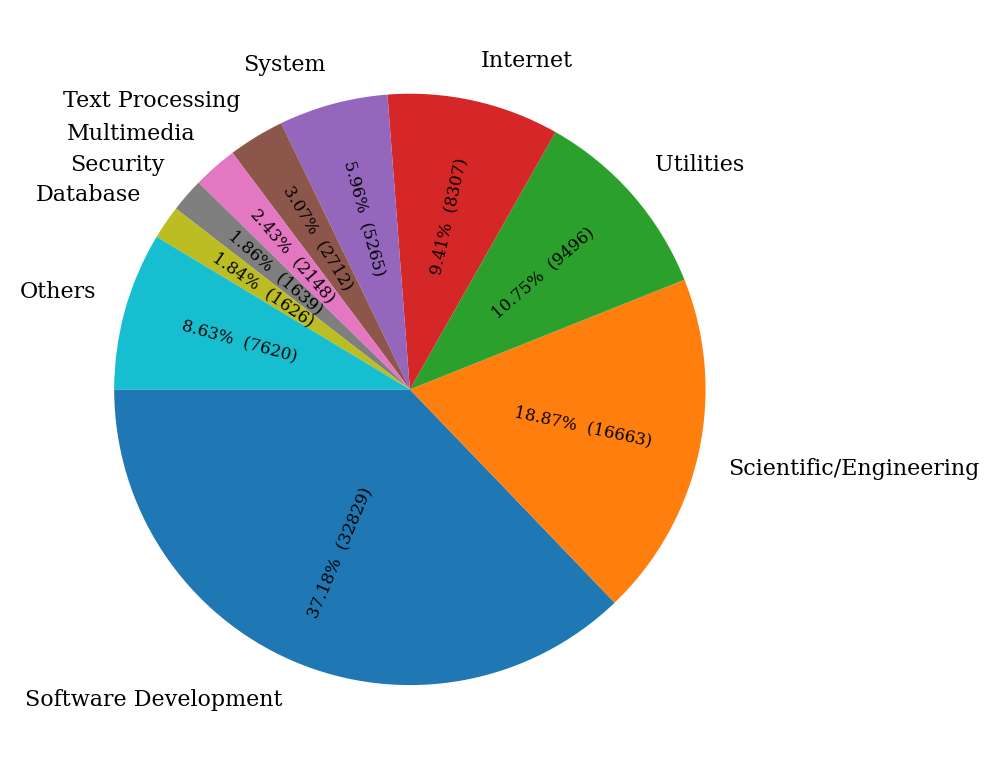

In [66]:
thresh = 1550
plot_pie_chart('Topic First Order', thresh_for_others=thresh)

### Pie chart of topic distribution for column Topics for Propagation

100%|██████████| 185242/185242 [00:00<00:00, 4138275.69it/s]


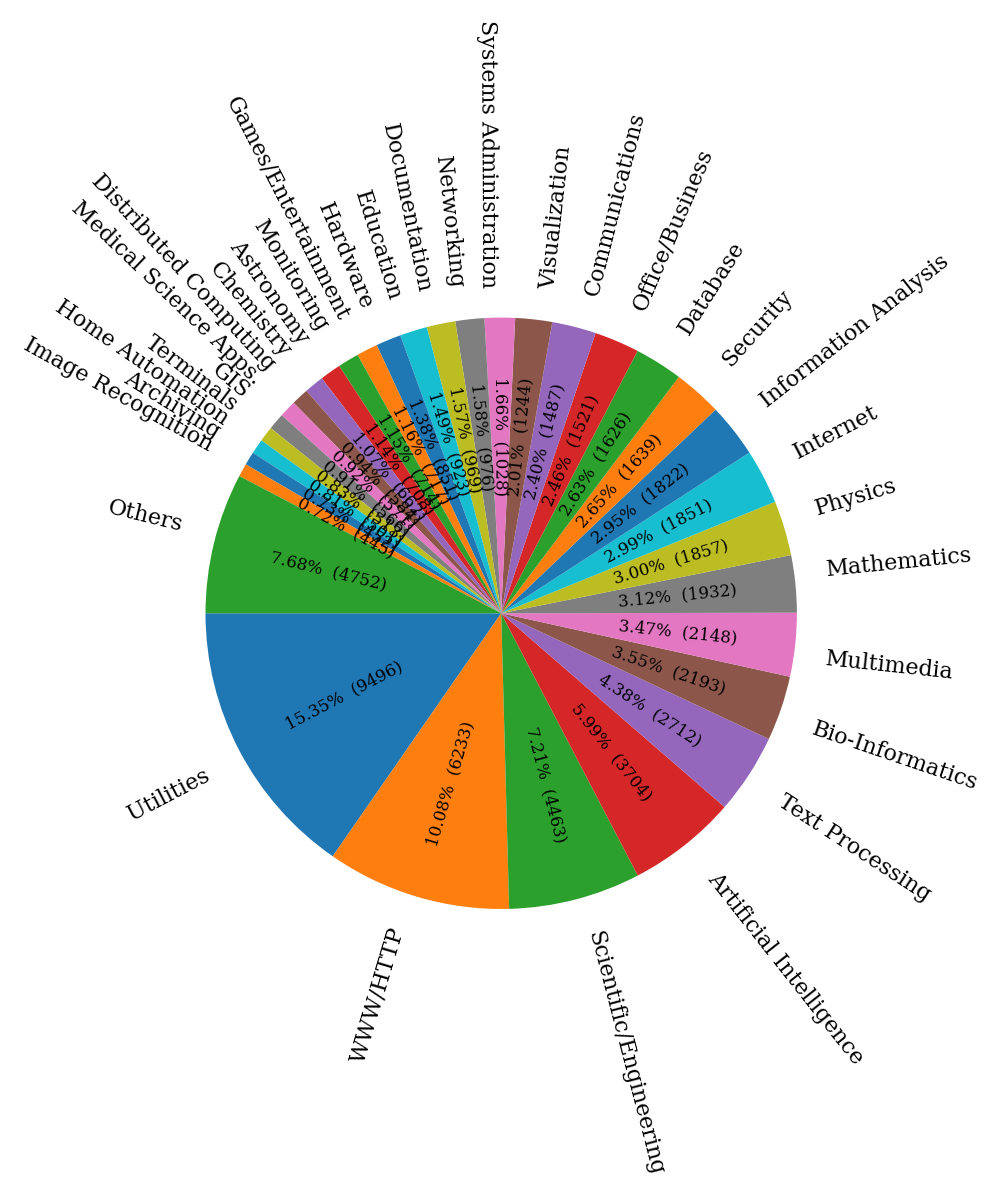

In [32]:
plot_pie_chart('Topics for Propagation', thresh_for_others=400)

### Pie chart of subtopics of science/engeniering

100%|██████████| 185242/185242 [00:00<00:00, 1802071.35it/s]


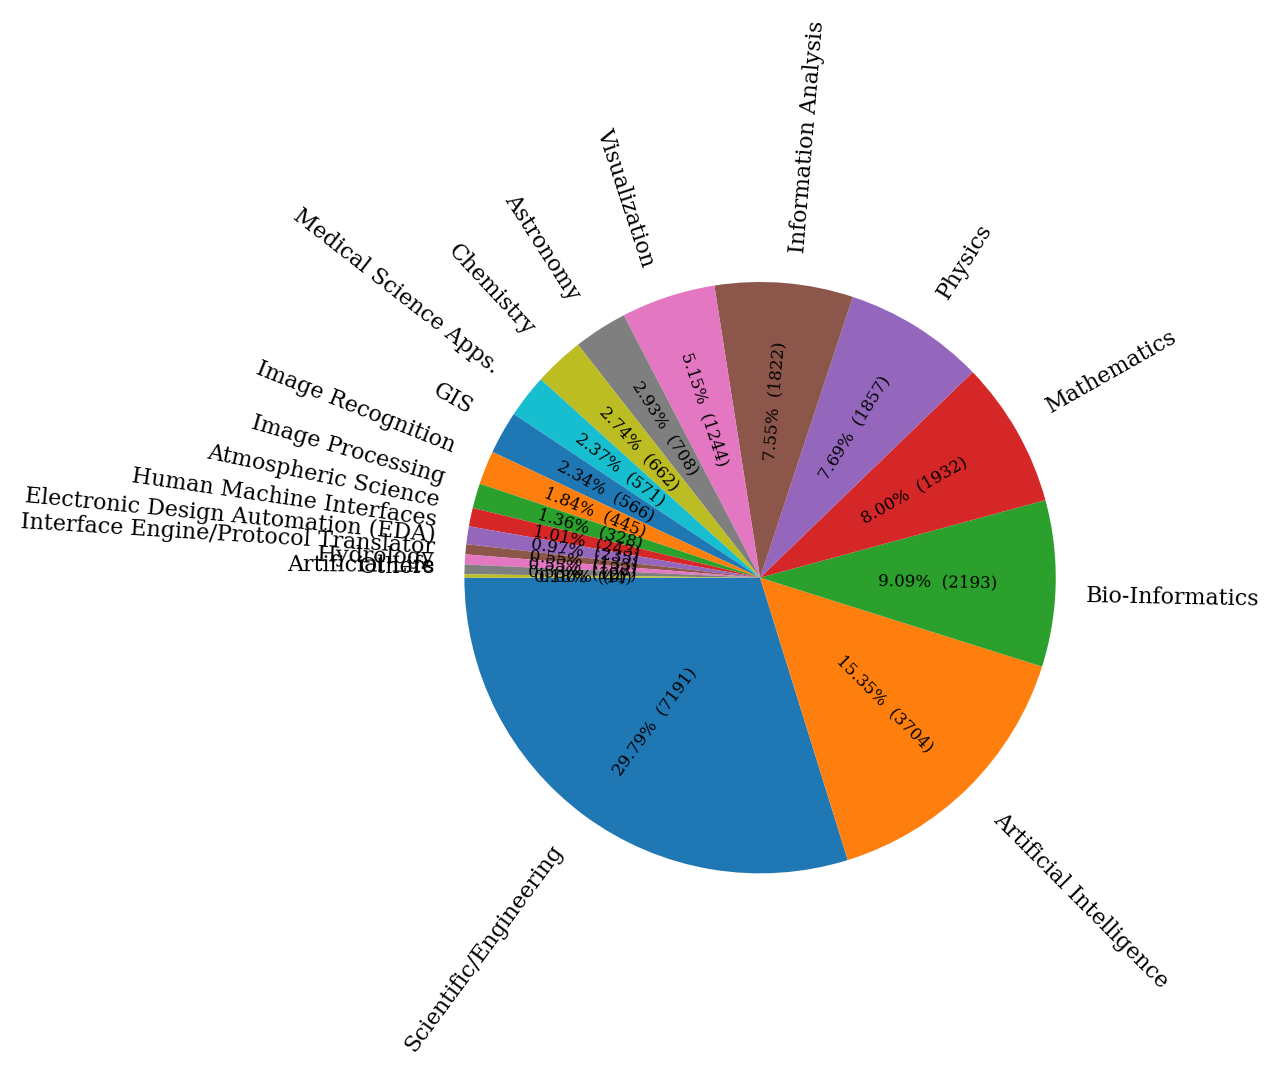

In [48]:
thresh = 20
plot_pie_chart('Topic Scientific/Engineering', thresh_for_others=thresh)

### Pie chart of subtopics of Utilities

In [53]:
### Utilities no tiene subtopics...
utilities_topic = {k: v for k, v in topics_counter.items() if k.startswith('Utilities')}
utilities_topic

{'Utilities': 9496}

### Pie chart of subtopics of Internet

100%|██████████| 185242/185242 [00:00<00:00, 3066472.20it/s]


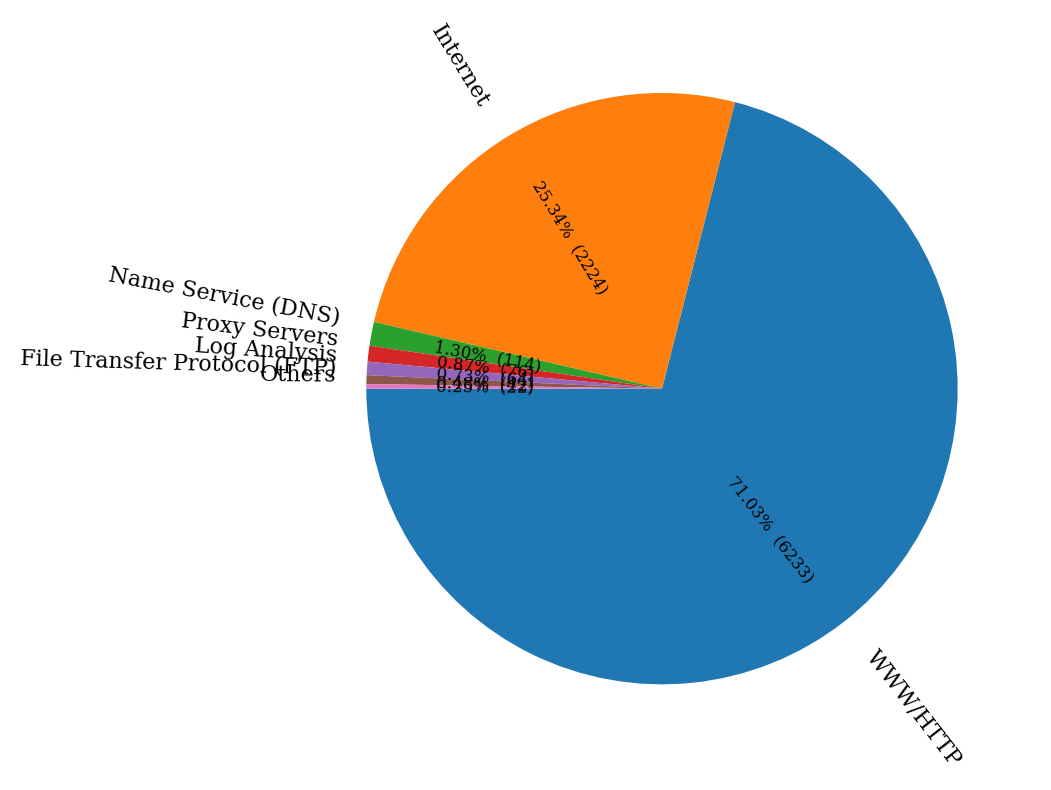

In [ ]:
thresh = 20
plot_pie_chart('Topic Internet', thresh_for_others=thresh)

### Pie chart of subtopics of System

100%|██████████| 185242/185242 [00:00<00:00, 3584050.69it/s]


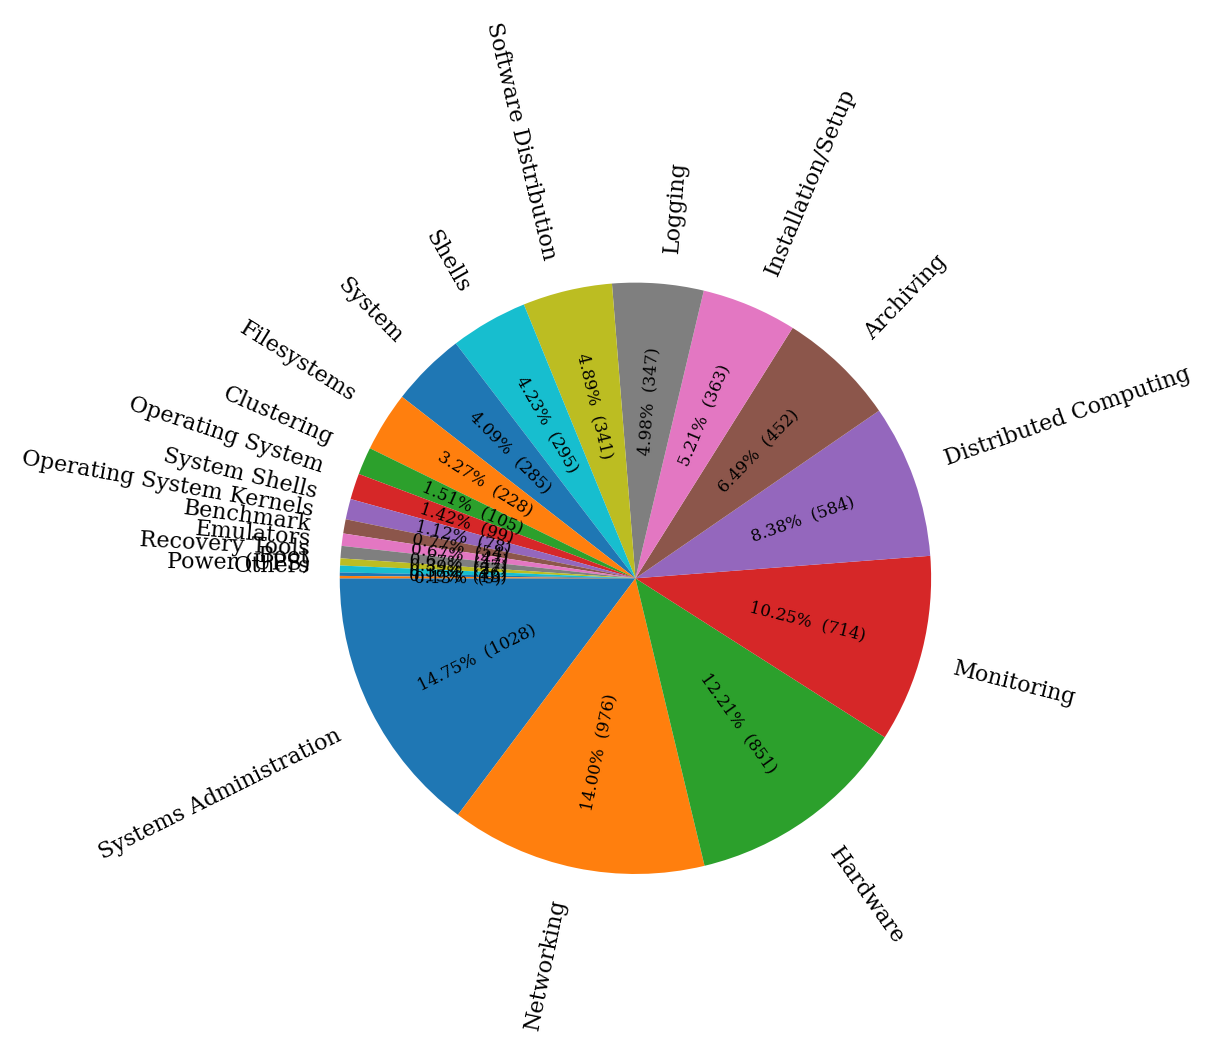

In [50]:
thresh = 10
plot_pie_chart('Topic System', thresh_for_others=thresh)

### Pie chart of Intended Audience

100%|██████████| 185242/185242 [00:00<00:00, 1121964.10it/s]


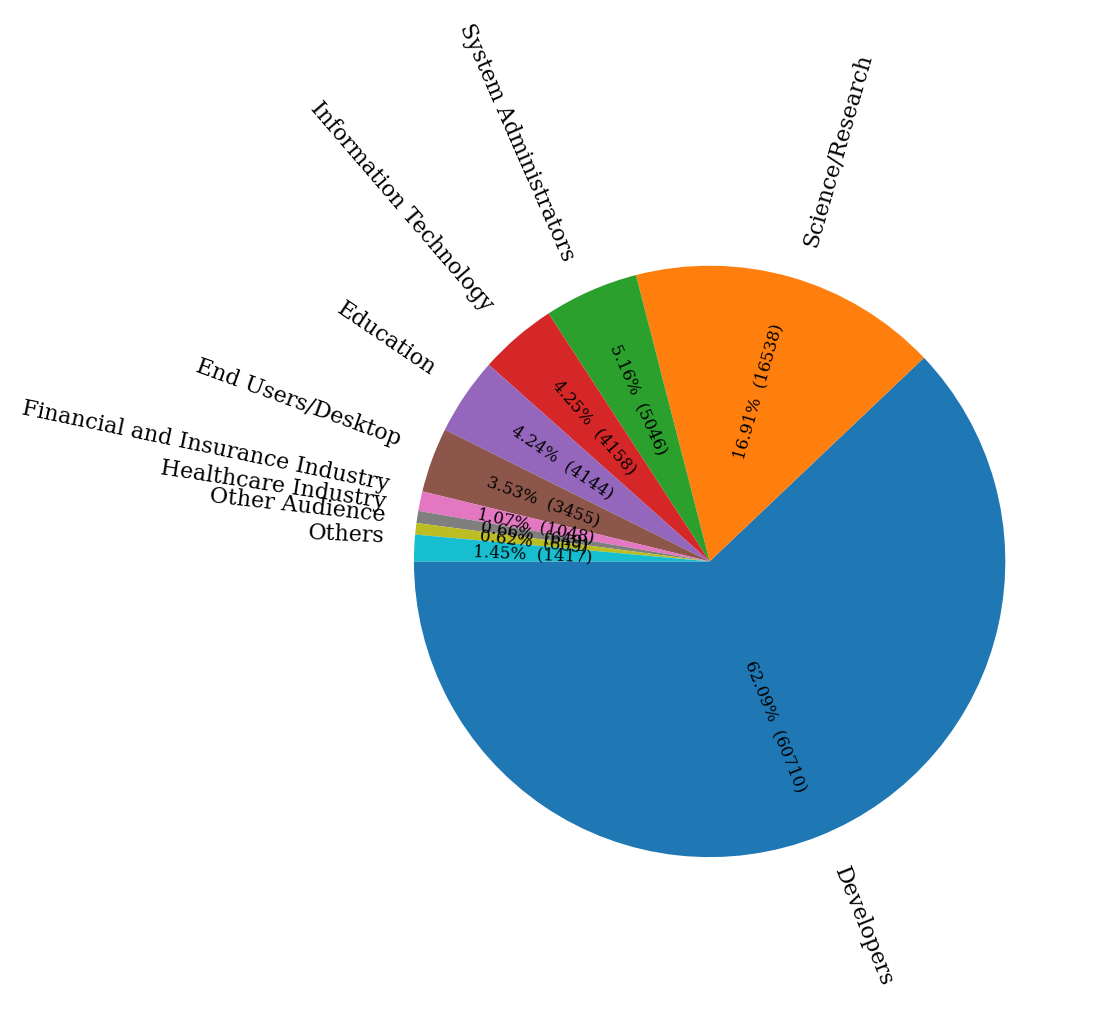

In [58]:
plot_pie_chart('Intended Audience', thresh_for_others=510)

In [59]:
df['Dependencies count'] = df['Dependencies'].apply(lambda x: len(x) if type(x) is list else 0)

In [60]:
dependencies_count = {k: v for k, v in df['Dependencies count'].items()}
dependencies_count = dict(sorted(dependencies_count.items(), key=lambda x: x[1], reverse=True))

In [61]:
print('librerias con mas dependencias:\n')
print(list(dependencies_count.items())[:10])

librerias con mas dependencias:

[('ai-python', 453), ('apache-airflow', 370), ('custom-workflow-solutions', 331), ('boto3-stubs-lite', 321), ('boto3-stubs', 321), ('types-aiobotocore-lite', 316), ('types-aiobotocore', 316), ('bitfount', 306), ('types-aioboto3-lite', 304), ('types-aioboto3', 304)]


# Guardado de archivos: Grafo y Dataframe

In [71]:
with open('PyPi Dataframe V4 with subtopics.df', 'wb') as f:
    pickle.dump(df, f)

In [36]:
edges = []
nodes = [n for n in df.index]

for node in nodes:
    dependencies = df.loc[node, 'Dependencies']
    
    if np.logical_and(type(dependencies) == list, bool(dependencies)):
        node_edges = [(dep, node) for dep in dependencies]
        edges += node_edges

In [37]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [38]:
nx.write_gexf(G, 'PyPi Network V4.gexf')